In [2]:
import BlackScholes as bs
import arviz as az
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import risk_free_rates as rf
import implied_q as iq
import time
import pymc as pm
import pytensor.tensor as pt
import variance_curve as vc
import Quintic

In [3]:
# Read the dataset

S0 = 4017.8

IV_df = pd.read_csv("hist_spx.csv")
moneyness = np.array([80.0,90.0,95.0,97.5,100.0,102.5,105.0,110.0,120.0])
maturities = np.array(IV_df['Exp Date']).flatten()
IV = np.array(IV_df.drop(columns = 'Exp Date'))/100.

K = S0 * moneyness / 100

maturities = maturities[1:11]
IV = IV[1:11,:]

# Starting parameters from deterministic calibration
data = pd.read_csv("quintic_parameters.csv")

#a_k = np.array([data.a0, data.a1, data.a3, data.a5]).flatten()
a_k = np.array([1.2236844973767875, 0.45027430292716225, 0.036060072348015164, 0.05319950954795843])

In [8]:
nr = len(maturities); nc = len(K)
N = 5000; n = 300;
T = maturities[-1]; steps = np.ceil(n*maturities/T).astype(int);
w = np.concatenate((np.zeros([1,N*2]), Quintic.dW(n, N)))

In [9]:
r = rf.r(maturities)
q = list()
for i in range(nr):
    q.append(iq.q(maturities[i]))
q = np.array(q)

true_price = np.zeros([nr,nc])

for i in range(nr):
    tau = maturities[i]
    for j in range(nc):
        true_price[i,j] = bs.BSCall(S0, K[j], tau, r[i], q[i], IV[i,j])
true_price = true_price.flatten()

In [10]:
def f(rho, H, eps, size = None):
    return Quintic.global_reduction(rho, H, eps, T, a_k, S0, K, n, N, w, steps, maturities).flatten()

In [11]:
%%timeit
f(-0.8, 0.1, 0.01)

412 ms ± 5.97 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
def f(rng, rho, H, eps, size = None):
    return Quintic.global_reduction(rho, H, eps, T, a_k, S0, K, n, N, w, steps, maturities).flatten()

In [13]:
start_time = time.time()

with pm.Model() as model_lv:
    
    rho = pm.Uniform("rho", lower = -1, upper = -0.1)
    H = pm.Uniform("H", lower = 0, upper = 0.15)
    eps = pm.Uniform("eps", lower = 0.015, upper = 0.15)

    sim = pm.Simulator("sim", f, params = (rho, H, eps), epsilon = 10, observed = true_price)

    idata_lv = pm.sample_smc(draws = 2000, chains = 4, progressbar=False)
    
print(f'Elapsed time: {time.time()-start_time: .2f}s')

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Elapsed time:  64855.63s


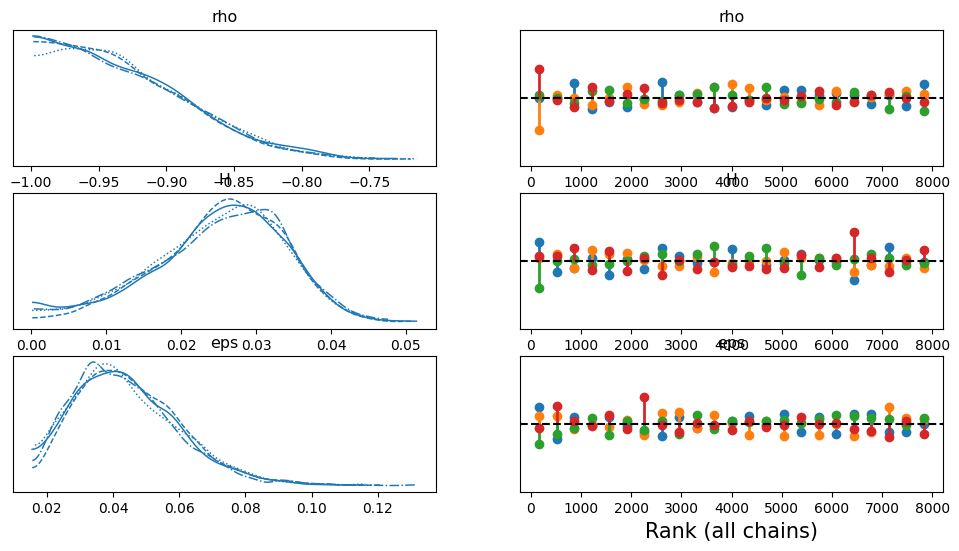

In [14]:
az.plot_trace(idata_lv, kind="rank_vlines");

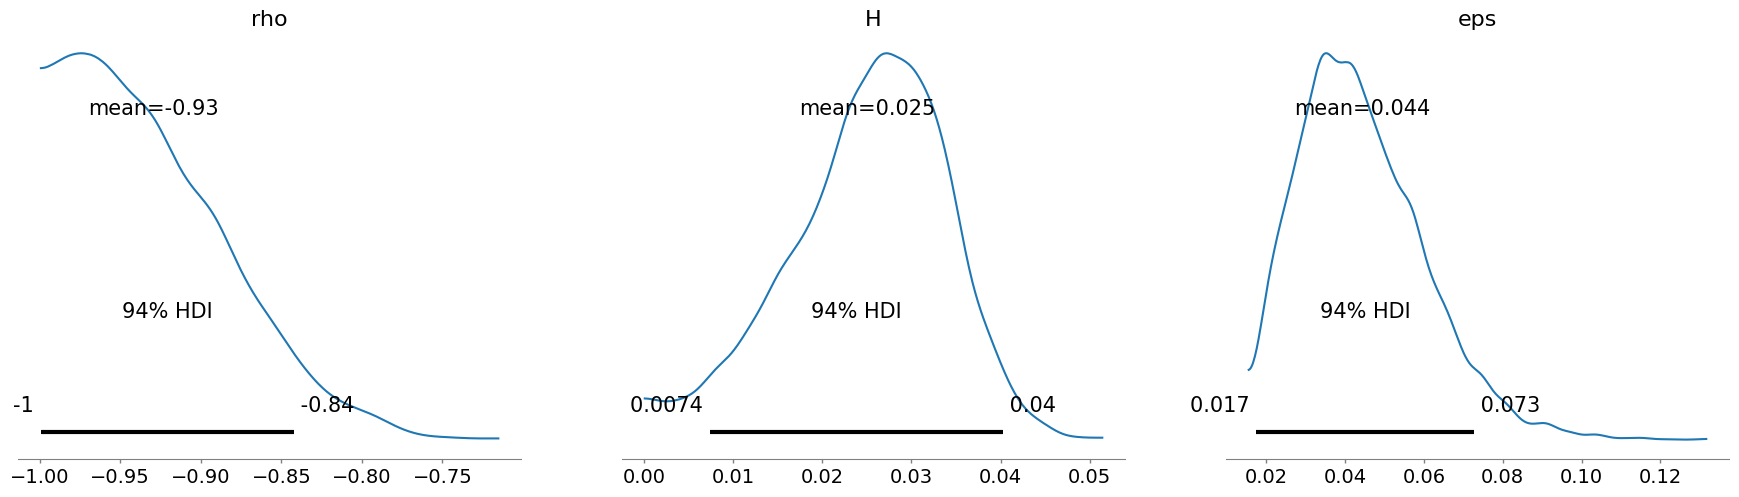

In [15]:
az.plot_posterior(idata_lv);

In [16]:
rho = np.array(pd.DataFrame(idata_lv.posterior.rho)).flatten()
H = np.array(pd.DataFrame(idata_lv.posterior.H)).flatten()
eps = np.array(pd.DataFrame(idata_lv.posterior.eps)).flatten()

Rho: -0.963529048591099


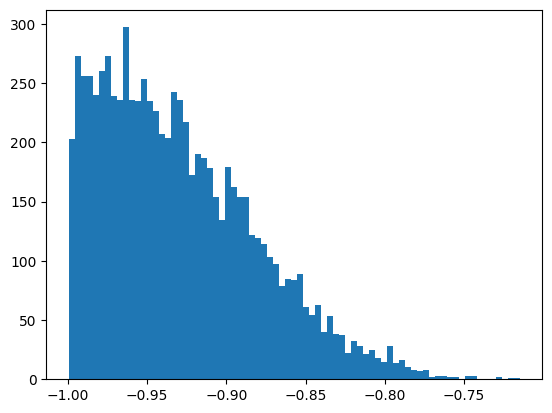

In [17]:
a = plt.hist(rho, bins = 75)

x = (a[1][:-1] + a[1][1:])/2; y = a[0]
x_max = x[np.argmax(y)]
print("Rho:", x_max)

H: 0.026427625768152135


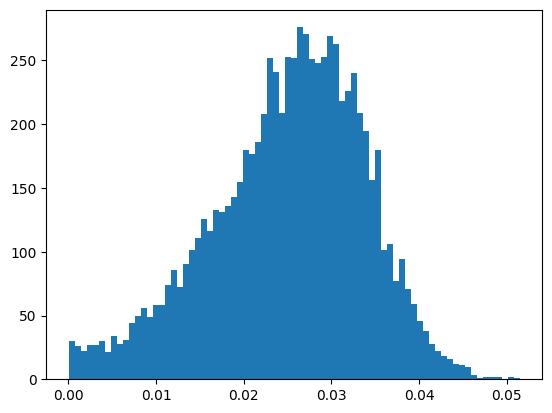

In [18]:
a = plt.hist(H, bins = 75)

x = (a[1][:-1] + a[1][1:])/2; y = a[0]
x_max = x[np.argmax(y)]
print("H:", x_max)

Eps: 0.03327797663980596


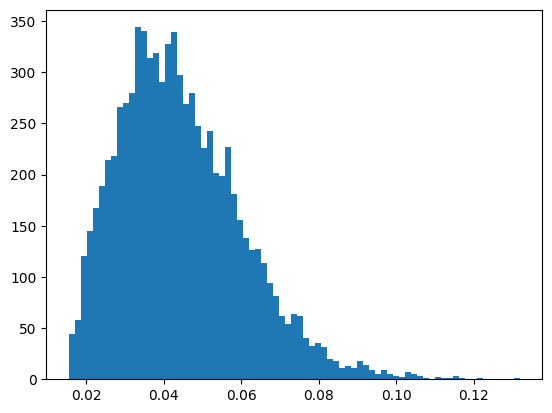

In [19]:
a = plt.hist(eps, bins = 75)

x = (a[1][:-1] + a[1][1:])/2; y = a[0]
x_max = x[np.argmax(y)]
print("Eps:", x_max)